In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
lr = 0.0001
batch_size = 64
train_data = True

In [3]:
mnist = MNIST(
    root='./data',
    train=train_data,
    transform=transforms.ToTensor(),
    download=True)

dataloader = DataLoader(
    dataset=mnist,
    batch_size=batch_size,
    shuffle=True)

criterion = nn.BCELoss()

def write(model, w=5, h=1, size=2):
    n = w*h
    x = torch.randn(n, 100, 1, 1).to(device)
    images = model(x).reshape(n, 28, 28)
    plt.figure(figsize=(size*w, size*h))
    for i, image in enumerate(images, 1):
        plt.subplot(h, w, i)
        img = image.cpu().detach().numpy()
        plt.imshow(img, cmap="gray")
        plt.tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False)
        plt.tight_layout()
    plt.show()

def train(images):
    netD.zero_grad()
    batch_size=len(images)
    label_real = torch.ones((batch_size, 1)).to(device)
    label_fake = torch.zeros((batch_size, 1)).to(device)

    y_real = netD(images)
    lossD_real = criterion(y_real, label_real)

    noise = torch.randn(batch_size, 100, 1, 1).to(device)
    fake = netG(noise)
    y_fake = netD(fake)
    lossD_fake = criterion(y_fake, label_fake)

    lossD = lossD_real + lossD_fake
    lossD.backward(retain_graph=True)
    optimD.step()

    netG.zero_grad()

    y_fake = netD(fake)
    lossG = criterion(y_fake, label_real)
    lossG.backward(retain_graph=True)
    optimG.step()

    return lossD, lossG

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.convT(100, 512, 3, 1, 0),
            self.convT(512, 256, 4, 1, 0),
            self.convT(256, 128, 4, 2, 0),
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Sigmoid())

    def convT(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())
        return net

    def forward(self, x):
        y = self.net(x)
        return y

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.conv(1, 128, 4, 2, 0),
            self.conv(128, 256, 3, 2, 0),
            self.conv(256, 512, 4, 2, 1),
            nn.Conv2d(512, 512, 3, 1, 0),
            nn.Flatten(),
            nn.Linear(512, 128),
            # nn.BatchNorm1d(128), # これがあるとうまくいかない
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def conv(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net
    
    def linear(self, in_channels, out_channels):
        net = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net
    
    def forward(self, x):
        y = self.net(x)
        return y

In [9]:
netG = Generator().to(device)
netD = Discriminator().to(device)
optimG = optim.Adam(netG.parameters(), lr=lr)
optimD = optim.Adam(netD.parameters(), lr=lr)

In [10]:
n_epochs = 10

初期状態


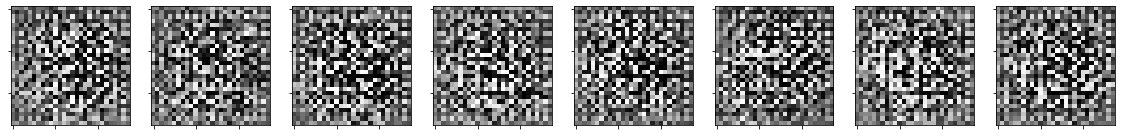

  1epoch lossD:0.002930709859356284 lossG:9.644271850585938


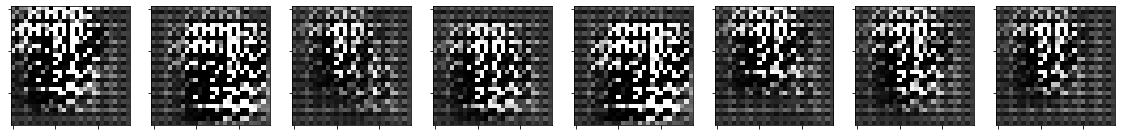

  2epoch lossD:0.02248801849782467 lossG:7.179830551147461


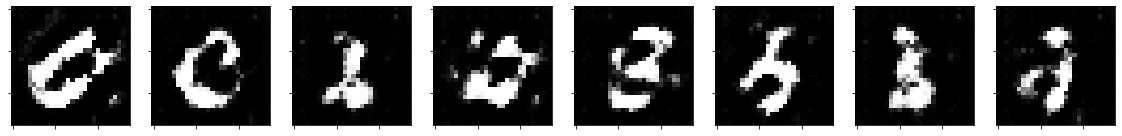

  3epoch lossD:0.08197949081659317 lossG:5.483227252960205


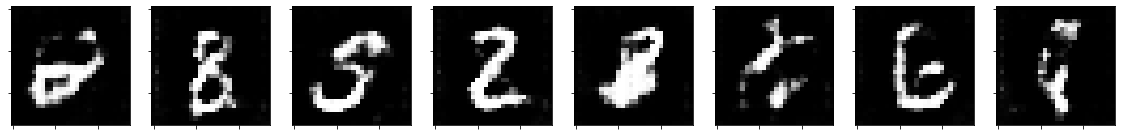

  4epoch lossD:0.07490646094083786 lossG:5.866321563720703


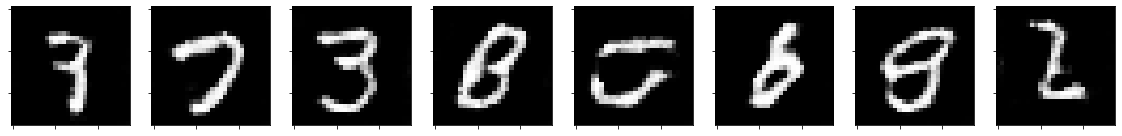

  5epoch lossD:0.3685791492462158 lossG:6.824947357177734


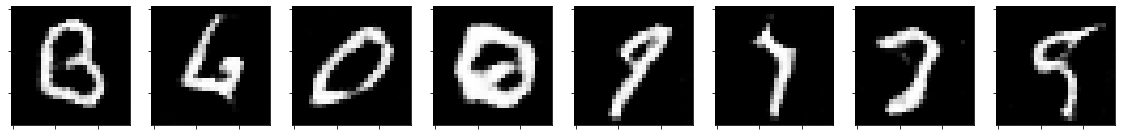

  6epoch lossD:0.3559146523475647 lossG:4.8325653076171875


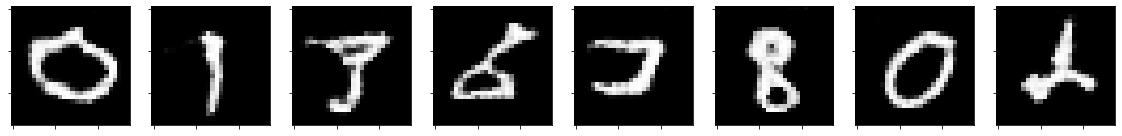

  7epoch lossD:0.02750851958990097 lossG:6.8162736892700195


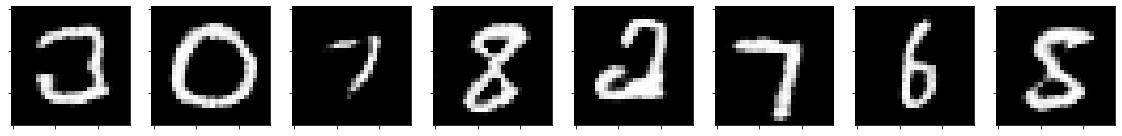

  8epoch lossD:0.20940028131008148 lossG:3.92948842048645


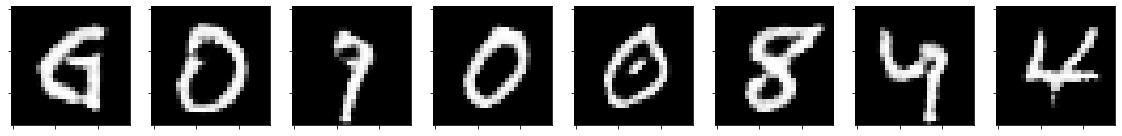

  9epoch lossD:0.07609470188617706 lossG:4.927448272705078


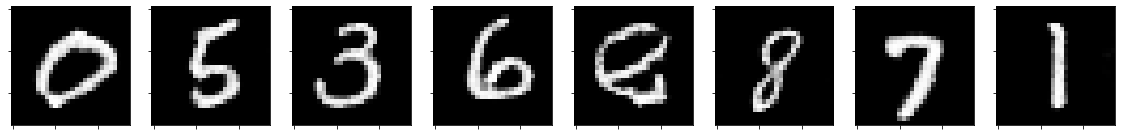

 10epoch lossD:0.12610700726509094 lossG:2.8683948516845703


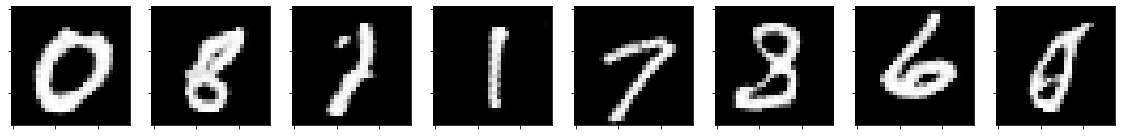

In [11]:
print('初期状態')
write(netG, w=8)
netD.train()
netG.train()
for epoch in range(n_epochs):
    for (images, _) in dataloader:
        lossD, lossG = train(images.cuda())
    print(f'{epoch+1:>3}epoch lossD:{lossD} lossG:{lossG}')
    write(netG, w=8)